# 📚 Automated Machine Learning-Regression

This notebook provides Automated Machine Learning (AutoML) algorithms for a regression task. Data preparation is just simply performed as the pre-processing will be automatically done, followed by building Machine Learning algorithms and tuning the hyperparameters. The objective of this notebook is to serve as a cheat sheet.

In [4]:
# Import packages
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from math import floor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score

# Evaluation and bayesian optimization
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [5]:
# Load dataset
trainSet = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv').drop(columns=['Id'])
testSet = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv').drop(columns=['Id'])
submitSet = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

trainSet.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Drop columns with too much NA
train = trainSet.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=0)

# Fill missing value with median or most occurance value
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
train['MasVnrType'] = train['MasVnrType'].fillna(train['MasVnrType'].value_counts().idxmax())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].median())
train['MasVnrType'] = train['MasVnrType'].fillna(train['MasVnrType'].value_counts().idxmax())
train['BsmtQual'] = train['BsmtQual'].fillna(train['BsmtQual'].value_counts().idxmax())
train['BsmtCond'] = train['BsmtCond'].fillna(train['BsmtCond'].value_counts().idxmax())
train['BsmtExposure'] = train['BsmtExposure'].fillna(train['BsmtExposure'].value_counts().idxmax())
train['BsmtFinType1'] = train['BsmtFinType1'].fillna(train['BsmtFinType1'].value_counts().idxmax())
train['BsmtFinType2'] = train['BsmtFinType2'].fillna(train['BsmtFinType2'].value_counts().idxmax())
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].value_counts().idxmax())
train['GarageType'] = train['GarageType'].fillna(train['GarageType'].value_counts().idxmax())
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].median())
train['GarageFinish'] = train['GarageFinish'].fillna(train['GarageFinish'].value_counts().idxmax())
train['GarageQual'] = train['GarageQual'].fillna(train['GarageQual'].value_counts().idxmax())
train['GarageCond'] = train['GarageCond'].fillna(train['GarageCond'].value_counts().idxmax())

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [8]:
# Encode categorical val
train = pd.get_dummies(train)
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDriv

In [9]:
selected = ['BsmtQual_Gd', 'SaleType_New', 'Fireplaces', 'BsmtExposure_Gd', '2ndFlrSF',
            'BsmtFinType1_GLQ', 'BsmtFinSF1', 'LowQualFinSF', 'GarageType_Detchd',
            'KitchenAbvGr', 'MSZoning_RM', 'TotalBsmtSF', 'CentralAir_N', 'GrLivArea',
            'KitchenQual_Ex', 'Exterior2nd_CmentBd', 'GarageCars', 'LandSlope_Gtl',
            'BsmtQual_Ex', 'OverallQual', 'SalePrice']

To find the process of feature selection, please visit this notebook https://www.kaggle.com/rendyk/regression-rmse-house-prices

That notebook demonstrates regression using conventional Machine Learning algorithms for learning the same dataset.

In [10]:
train_sel = train.loc[:,selected]

# train validation split
X_train, X_val, y_train, y_val = train_test_split(train_sel.drop(columns=['SalePrice']),
                                                  train_sel['SalePrice'],
                                                  test_size=0.2, random_state=123)

# 1. Auto-Sklearn

In [1]:
!apt install -y build-essential swig curl
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn
!pip install scipy==1.7.0
!pip install -U scikit-learn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
curl is already the newest version (7.58.0-2ubuntu3.13).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   249  100   249    0     0   2075      0 --:--:-- --:--:-- --:--:--  2075


In [2]:
from autosklearn.regression import AutoSklearnRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
# Create the model
sklearn = AutoSklearnRegressor(time_left_for_this_task=3*60, per_run_time_limit=30, n_jobs=-1)

# Fit the training data
sklearn.fit(X_train, y_train)

# Sprint Statistics
print(sklearn.sprint_statistics())

# Predict the validation data
pred_sklearn = sklearn.predict(X_val)

# Compute the RMSE
rmse_sklearn=MSE(y_val, pred_sklearn)**0.5
print('RMSE: ' + str(rmse_sklearn))

auto-sklearn results:
  Dataset name: c40b5794-fa4a-11eb-8116-0242ac130202
  Metric: r2
  Best validation score: 0.888788
  Number of target algorithm runs: 37
  Number of successful target algorithm runs: 23
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 8
  Number of target algorithms that exceeded the memory limit: 6

RMSE: 27437.715258009852


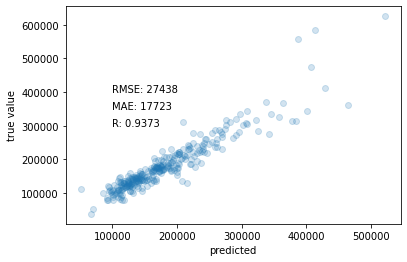

In [29]:
# Scatter plot true and predicted values
plt.scatter(pred_sklearn, y_val, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 400000, 'RMSE: ' + str(round(rmse_sklearn)))
plt.text(100000, 350000, 'MAE: ' + str(round(mean_absolute_error(y_val, pred_sklearn))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(y_val, pred_sklearn)[0,1],4)))
plt.show()

In [13]:
# Show the models
print(sklearn.show_models())

[(0.560000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'ard_regression', 'feature_preprocessor:polynomial:degree': 2, 'feature_preprocessor:polynomial:include_bias': 'True', 'feature_preprocessor:polynomial:interaction_only': 'False', 'regressor:ard_regression:alpha_1': 0.0003701926442639788, 'regressor:ard_regression:alpha_2': 2.2118001735899097e-07, 'regressor:ard_regression:fit_intercept': 'True', 'regressor:ard_regression:lambda_1': 1.2037591637980971e-06, 'regressor:ard_regression:lambda_2': 4.358378124977852e-09, 'regressor:ard_regression:n_iter': 300, 'regressor:ard_regressio

# 2. Tree-based Pipeline Optimization Tool (TPOT)

In [20]:
from tpot import TPOTRegressor

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [30]:
# Create model
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=123) 
tpot = TPOTRegressor(generations=5, population_size=5, cv=cv, scoring='neg_mean_absolute_error', verbosity=2, random_state=123, n_jobs=-1)

# Fit the training data
tpot.fit(X_train, y_train)

# Export the result
tpot.export('tpot_model.py')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -20390.588131563232

Generation 2 - Current best internal CV score: -19654.82630417806

Generation 3 - Current best internal CV score: -19312.09139004322

Generation 4 - Current best internal CV score: -19312.09139004322

Generation 5 - Current best internal CV score: -18752.921100941825

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.25, min_samples_leaf=3, min_samples_split=2, n_estimators=100)


Below is the tpot_model.py with a little adjustment.

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# This part is replaced with the below part
#tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
#features = tpot_data.drop('target', axis=1)
#training_features, testing_features, training_target, testing_target = \
#            train_test_split(features, tpot_data['target'], random_state=123)

# This part replaces the previous part
training_features = X_train
testing_features = X_val
training_target= y_train
testing_target = y_val

# Average CV score on the training set was: -18752.921100941825
exported_pipeline = RandomForestRegressor(bootstrap=True, max_features=0.25, min_samples_leaf=3, min_samples_split=2, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 123)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


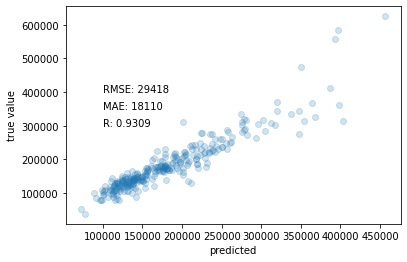

In [36]:
pred_tpot = results

# Scatter plot true and predicted values
plt.scatter(pred_tpot, y_val, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 400000, 'RMSE: ' + str(round(MSE(y_val, pred_tpot)**0.5)))
plt.text(100000, 350000, 'MAE: ' + str(round(mean_absolute_error(y_val, pred_tpot))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(y_val, pred_tpot)[0,1],4)))
plt.show()

# 3. Hyperopt

In [21]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn.git

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


  Cloning https://github.com/hyperopt/hyperopt-sklearn.git to /tmp/pip-req-build-ng9615ex
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn.git /tmp/pip-req-build-ng9615ex
  Resolved https://github.com/hyperopt/hyperopt-sklearn.git to commit c66f8df76003b5e72cb242399eeb139f951a1883
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-py3-none-any.whl size=27009 sha256=45804080d737cf7e57c79ae98c52a641c6a477cc74fbfe7e290e45af75b44df2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8s2wyde6/wheels/47/a5/46/9ca750026db9dfa5de4bf4836194554cb0e2e01a245588ea59
Successfully built hpsklearn
  Attempting uninstall: hpsklearn
    Found existing installation: hpsklearn 0.1.0
    Uninstalling hpsklearn-0.1.0:
      Successfully uninstalled hpsklearn-0.1.0


In [22]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
from sklearn.metrics import mean_squared_error

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [33]:
# Convert data into array
X_train_ar = np.array(X_train)
X_val_ar = np.array(X_val)
y_train_ar = np.array(y_train)
y_val_ar = np.array(y_val)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [34]:
# Create the model
hyperopt = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'),
                             loss_fn=mean_squared_error, algo=tpe.suggest, max_evals=50,
                             trial_timeout=20)

# Fit the data
hyperopt.fit(X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


 95%|█████████▌| 20/21 [00:00<?, ?trial/s, best loss=?]

0 should be passed as minlength instead of None; this will error in future.



100%|██████████| 50/50 [00:00<00:00,  2.92trial/s, best loss: 740163129.8904691]


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


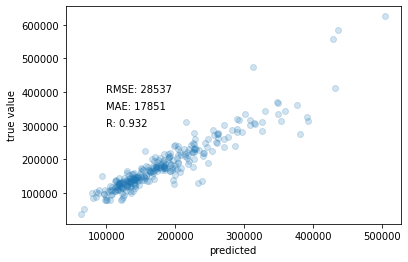

In [35]:
# Predict the validation data
pred_hyperopt = hyperopt.predict(X_val)

# Scatter plot true and predicted values
plt.scatter(pred_hyperopt, y_val, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 400000, 'RMSE: ' + str(round(MSE(y_val_ar, pred_hyperopt)**0.5)))
plt.text(100000, 350000, 'MAE: ' + str(round(mean_absolute_error(y_val_ar, pred_hyperopt))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(y_val_ar, pred_hyperopt)[0,1],4)))
plt.show()

In [37]:
# Show the models
print(hyperopt.best_model())

{'learner': XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6209369845565308, colsample_bynode=1,
             colsample_bytree=0.6350745975782562, gamma=0.07330922089021298,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0040826994703554555, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2600, n_jobs=1,
             num_parallel_tree=1, objective='reg:linear', random_state=3,
             reg_alpha=0.4669165283261672, reg_lambda=2.2280355282357056,
             scale_pos_weight=1, seed=3, subsample=0.7295609371405459,
             tree_method='exact', validate_parameters=1, verbosity=None), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# 4. AutoKeras

In [14]:
!pip install autokeras

     |████████████████████████████████| 166 kB 594 kB/s eta 0:00:01


In [15]:
import autokeras

In [38]:
# Create the model
keras = autokeras.StructuredDataRegressor(max_trials=8)

# Fit the training dataset
keras.fit(X_train, y_train, epochs=100)

# Predict the validation data
pred_keras = keras.predict(X_val)

Trial 8 Complete [00h 00m 06s]
val_loss: 4774688768.0

Best val_loss So Far: 4774688768.0
Total elapsed time: 00h 03m 28s
Epoch 1/100
37/37 [==============================] - 1s 2ms/step - loss: 39509297690.9474 - mean_squared_error: 39509297690.9474
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 36400142551.5789 - mean_squared_error: 36400142551.5789
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 26316775262.3158 - mean_squared_error: 26316775262.3158
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 10495081081.2632 - mean_squared_error: 10495081081.2632
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 2845539092.2105 - mean_squared_error: 2845539092.2105
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 2488755516.6316 - mean_squared_error: 2488755516.6316
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 2464459334.7368 - mean_squared_erro

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


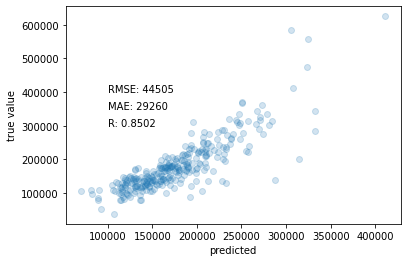

In [39]:
# Convert predicted result into pandas series with numeric type
pred_keras_ = pd.DataFrame(pred_keras)
pred_keras_ = pred_keras_[0]
pred_keras_ = pd.to_numeric(pred_keras_)

# Scatter plot true and predicted values
plt.scatter(pred_keras_, y_val, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 400000, 'RMSE: ' + str(round(MSE(y_val_ar, pred_keras_)**0.5)))
plt.text(100000, 350000, 'MAE: ' + str(round(mean_absolute_error(y_val_ar, pred_keras_))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(y_val_ar, pred_keras_)[0,1],4)))
plt.show()

In [40]:
# Show the built models
keras_export = keras.export_model()
keras_export.summary() # Scroll to the end of the warnings to find the neural network summary

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


[WARNING] [2021-08-11 03:05:34,236:tensorflow] 11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x7fc21cf550e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[WARNING] [2021-08-11 03:05:34,244:tensorflow] 11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x7fc21cf51b00> triggered tf.function retracing. Tracing is expensive and the excessive number of

# 5. MLJAR

In [16]:
!pip install -q -U git+https://github.com/mljar/mljar-supervised.git@master

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.8.0.post0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.17 which is incompatible.


In [17]:
from supervised.automl import AutoML

In [23]:
# Create the model
mljar = AutoML(mode="Compete",  eval_metric="rmse", total_time_limit=300,
               features_selection=True)

# Fit the training data
mljar.fit(X_train, y_train)

AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Decision Tree', 'Linear', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree rmse 37687.582663 trained in 0.89 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 5-fold CV Shuffle
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree rmse 45567.674367 trained in 2.56 seconds
2_DecisionTree rmse 39836.374967 trained in 2.22 seconds
3_DecisionTree rmse 39836.374967 trained in 2.19 se

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


6_Default_Xgboost rmse 30064.536497 trained in 4.38 seconds
7_Default_CatBoost rmse 27961.416228 trained in 4.35 seconds
8_Default_NeuralNetwork rmse 33926.778641 trained in 3.67 seconds
9_Default_RandomForest rmse 35060.852948 trained in 7.51 seconds
10_Default_ExtraTrees rmse 37152.305342 trained in 8.36 seconds
11_Default_NearestNeighbors rmse 35652.860853 trained in 3.95 seconds
* Step not_so_random will try to check up to 61 models
21_LightGBM rmse 31230.274165 trained in 4.38 seconds


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


12_Xgboost rmse 31239.753358 trained in 4.76 seconds
30_CatBoost rmse 28204.635939 trained in 10.44 seconds
39_RandomForest rmse 33280.60989 trained in 8.35 seconds
48_ExtraTrees rmse 36919.336334 trained in 7.57 seconds
57_NeuralNetwork rmse 39725.237746 trained in 4.05 seconds
66_NearestNeighbors rmse 34752.01557 trained in 4.35 seconds
22_LightGBM rmse 30386.426528 trained in 4.02 seconds


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


13_Xgboost rmse 31340.402465 trained in 5.68 seconds
31_CatBoost rmse 30340.155252 trained in 7.57 seconds
40_RandomForest rmse 37837.385868 trained in 8.25 seconds
49_ExtraTrees rmse 40846.771892 trained in 7.24 seconds
58_NeuralNetwork rmse 30919.991138 trained in 5.18 seconds
* Step golden_features will try to check up to 3 models
None 10
Add Golden Feature: MSZoning_RM_diff_OverallQual
Add Golden Feature: OverallQual_sum_BsmtQual_Ex
Add Golden Feature: GarageType_Detchd_diff_OverallQual
Add Golden Feature: LandSlope_Gtl_diff_OverallQual
Add Golden Feature: CentralAir_N_diff_OverallQual
Add Golden Feature: LowQualFinSF_diff_OverallQual
Add Golden Feature: KitchenAbvGr_diff_OverallQual
Add Golden Feature: OverallQual_sum_GarageCars
Add Golden Feature: KitchenAbvGr_ratio_OverallQual
Add Golden Feature: OverallQual_ratio_KitchenAbvGr
Created 10 Golden Features in 0.64 seconds.
7_Default_CatBoost_GoldenFeatures rmse 28045.077247 trained in 6.39 seconds
30_CatBoost_GoldenFeatures rmse 28

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


70_Xgboost rmse 30431.159695 trained in 6.42 seconds


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


71_Xgboost rmse 30676.24663 trained in 6.07 seconds
72_LightGBM rmse 30307.806333 trained in 5.15 seconds
* Step hill_climbing_2 will try to check up to 30 models
73_CatBoost rmse 28013.903227 trained in 6.01 seconds
74_CatBoost_GoldenFeatures rmse 28736.832599 trained in 6.35 seconds
75_CatBoost rmse 28542.94811 trained in 9.85 seconds
* Step boost_on_errors will try to check up to 1 model
7_Default_CatBoost_BoostOnErrors rmse 28205.794598 trained in 6.33 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 27482.612941 trained in 5.6 seconds
* Step stack will try to check up to 27 models
7_Default_CatBoost_Stacked rmse 28276.874033 trained in 9.42 seconds


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


6_Default_Xgboost_Stacked rmse 29339.222773 trained in 9.14 seconds
72_LightGBM_Stacked rmse 29812.592199 trained in 52.11 seconds
* Step ensemble_stacked will try to check up to 1 model
Ensemble_Stacked rmse 27417.662029 trained in 7.26 seconds
AutoML fit time: 347.93 seconds
AutoML best model: Ensemble_Stacked


AutoML(eval_metric='rmse', features_selection=True, mode='Compete',
       total_time_limit=300)

In [25]:
# Predict the training data
mljar_pred = mljar.predict(X_val)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


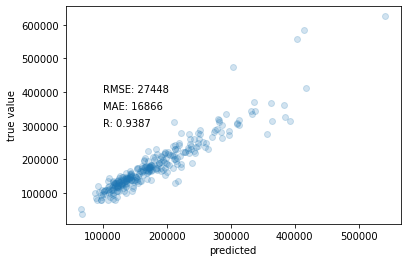

In [27]:
# Scatter plot true and predicted values
plt.scatter(mljar_pred, y_val, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 400000, 'RMSE: ' + str(round(MSE(y_val, mljar_pred)**0.5)))
plt.text(100000, 350000, 'MAE: ' + str(round(mean_absolute_error(y_val, mljar_pred))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(y_val, mljar_pred)[0,1],4)))
plt.show()

In [28]:
# Show the model results
mljar.report()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# 6. AutoGluon

In [18]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0"
!pip install autogluon  

     |████████████████████████████████| 1.6 MB 594 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2
     |████████████████████████████████| 819 kB 601 kB/s eta 0:00:01
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.6.0.post20210108
    Uninstalling setuptools-49.6.0.post20210108:
      Successfully uninstalled setuptools-49.6.0.post20210108
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
gcsfs 2021.6.0 requires fsspec==2021.06.0, but you have fsspec 2021.6.1 which is incompatible.
ea

In [19]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [41]:
# Prepare the data
Xy_train = X_train.reset_index(drop=True)
Xy_train['Target'] = y_train

Xy_val = X_val.reset_index(drop=True)
Xy_val['Target'] = y_val

X_train_gluon = TabularDataset(Xy_train)
X_val_gluon = TabularDataset(Xy_val)

# Fit the training data
gluon = TabularPredictor(label='Target').fit(X_train_gluon, time_limit=120)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


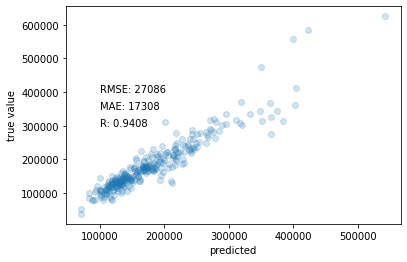

In [42]:
# Predict the training data
gluon_pred = gluon.predict(X_val)

# Scatter plot true and predicted values
plt.scatter(gluon_pred, y_val, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 400000, 'RMSE: ' + str(round(MSE(y_val_ar, gluon_pred)**0.5)))
plt.text(100000, 350000, 'MAE: ' + str(round(mean_absolute_error(y_val_ar, gluon_pred))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(y_val_ar, gluon_pred)[0,1],4)))
plt.show()

In [43]:
# Show the models
leaderboard = gluon.leaderboard(X_train_gluon)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


                  model     score_test      score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       RandomForestMSE  -15385.131260  -23892.159881        0.133275       0.104170   1.155124                 0.133275                0.104170           1.155124            1       True          5
1         ExtraTreesMSE  -15537.139720  -24981.601931        0.137063       0.104260   1.015925                 0.137063                0.104260           1.015925            1       True          7
2         LightGBMLarge  -17049.125557  -26269.841824        0.026560       0.005479   1.614854                 0.026560                0.005479           1.614854            1       True         11
3               XGBoost  -18142.996982  -23573.451829        0.054067       0.008095   0.371926                 0.054067                0.008095           0.371926            1       True          9
4    

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [44]:
# Show the models
leaderboard

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-15385.131260,-23892.159881,0.133275,0.104170,1.155124,0.133275,0.104170,1.155124,1,True,5
1,ExtraTreesMSE,-15537.139720,-24981.601931,0.137063,0.104260,1.015925,0.137063,0.104260,1.015925,1,True,7
2,LightGBMLarge,-17049.125557,-26269.841824,0.026560,0.005479,1.614854,0.026560,0.005479,1.614854,1,True,11
3,XGBoost,-18142.996982,-23573.451829,0.054067,0.008095,0.371926,0.054067,0.008095,0.371926,1,True,9
4,KNeighborsDist,-18418.785860,-41132.826848,0.135036,0.111236,0.002836,0.135036,0.111236,0.002836,1,True,2
5,CatBoost,-19585.309377,-23910.403833,0.004854,0.003402,0.593831,0.004854,0.003402,0.593831,1,True,6
6,WeightedEnsemble_L2,-20846.144676,-22060.013365,1.169406,0.978691,15.650282,0.005681,0.001055,0.660491,2,True,12
7,LightGBM,-23615.121228,-23205.065207,0.024396,0.005888,0.973314,0.024396,0.005888,0.973314,1,True,4
8,LightGBMXT,-25261.893395,-24608.580984,0.015091,0.008533,1.180441,0.015091,0.008533,1.180441,1,True,3
9,NeuralNetMXNet,-28904.712029,-24104.217749,0.819149,0.749686,12.484731,0.819149,0.749686,12.484731,1,True,10
